In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
import numpy as np 
import pandas as pd
import os
import shutil
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import Xception

In [3]:
df = pd.read_csv('data_llhajbb.csv',sep=',' )

AUTO = tf.data.experimental.AUTOTUNE

In [4]:
df.head()

,path_image,lebel
0,new_data0.jpeg,rouille
1,new_data1.jpeg,rouille
2,new_data2.jpeg,rouille
3,new_data3.jpeg,rouille
4,new_data4.jpeg,rouille


In [5]:
a=df.copy()
a=pd.get_dummies(a['lebel'])
df1=pd.concat([df, a], axis=1)
df1.head()

,path_image,lebel,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,puceron noir,puceron vert,rouille,scolytes
0,new_data0.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
1,new_data1.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
2,new_data2.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
3,new_data3.jpeg,rouille,0,0,0,0,0,0,0,0,1,0
4,new_data4.jpeg,rouille,0,0,0,0,0,0,0,0,1,0


In [6]:
data=df1[df1['puceron noir']!=1]

In [7]:
data=data[data['scolytes']!=1]
data=data[data['puceron vert']!=1]

In [8]:
data.drop(columns='lebel', inplace=True)

data.shape

(402, 11)

In [9]:
data.drop(columns=['puceron noir','scolytes','puceron vert'],inplace=True)

In [10]:
data.head()

,path_image,acariens,chancre fusicocum,coryneum,faux tigre,othyorinques,polystigma,rouille
0,new_data0.jpeg,0,0,0,0,0,0,1
1,new_data1.jpeg,0,0,0,0,0,0,1
2,new_data2.jpeg,0,0,0,0,0,0,1
3,new_data3.jpeg,0,0,0,0,0,0,1
4,new_data4.jpeg,0,0,0,0,0,0,1


In [11]:
data.columns

Index(['path_image', 'acariens', 'chancre fusicocum', 'coryneum', 'faux tigre',
       'othyorinques', 'polystigma', 'rouille'],
      dtype='object')

<ipython-input-12-e50005ee8130>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pcts=data.mean()


<AxesSubplot:ylabel='None'>

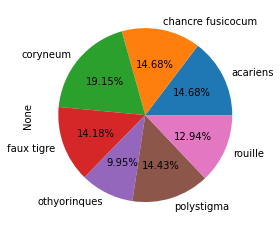

In [12]:
pcts=data.mean()
pcts.plot(kind = 'pie',autopct='%1.2f%%')

In [13]:
img_size={'height': 960,
         'width': 1280 }

In [14]:
data.shape

(402, 8)

In [15]:
path='paths/'
data_path=data.path_image.apply(lambda x: path +x).values

(1280, 958, 3)


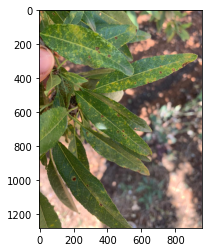

In [16]:
from matplotlib import pyplot as plt

img = plt.imread(path+'new_data1.jpeg')
print(img.shape)
plt.imshow(img)

In [17]:
data_path

array(['paths/new_data0.jpeg', 'paths/new_data1.jpeg',
       'paths/new_data2.jpeg', 'paths/new_data3.jpeg',
       'paths/new_data4.jpeg', 'paths/new_data5.jpeg',
       'paths/new_data6.jpeg', 'paths/new_data7.jpeg',
       'paths/new_data8.jpeg', 'paths/new_data9.jpeg',
       'paths/new_data10.jpeg', 'paths/new_data11.jpeg',
       'paths/new_data12.jpeg', 'paths/new_data13.jpeg',
       'paths/new_data14.jpeg', 'paths/new_data15.jpeg',
       'paths/new_data16.jpeg', 'paths/new_data17.jpeg',
       'paths/new_data18.jpeg', 'paths/new_data19.jpeg',
       'paths/new_data20.jpeg', 'paths/new_data21.jpeg',
       'paths/new_data22.jpeg', 'paths/new_data23.jpeg',
       'paths/new_data24.jpeg', 'paths/new_data25.jpeg',
       'paths/new_data26.jpeg', 'paths/new_data27.jpeg',
       'paths/new_data28.jpeg', 'paths/new_data29.jpeg',
       'paths/new_data30.jpeg', 'paths/new_data31.jpeg',
       'paths/new_data32.jpeg', 'paths/new_data33.jpeg',
       'paths/new_data34.jpeg', 'paths/ne

In [18]:
data_labels = data.loc[:, ['acariens', 'chancre fusicocum', 'faux tigre','othyorinques', 'polystigma','coryneum', 'rouille']].values

In [19]:
train_paths, test_paths, train_labels, test_labels =train_test_split(data_path, data_labels, test_size=0.2, random_state=42)


In [20]:
len(test_paths)

81

In [21]:
IMG_SIZE=1000
def decode_image(filename, label=None, IMG_SIZE=(IMG_SIZE, IMG_SIZE)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, IMG_SIZE)
    
    if label is None:
        return image
    else:
        return image, label


def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if label is None:
        return image
    else:
        return image, label

In [22]:
BATCH_SIZE = 8

train_dataset = (
tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .cache()
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_paths,test_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    
)

In [23]:
LR_START = 0.0001
LR_MAX = 0.00005 
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 4
LR_SUSTAIN_EPOCHS = 6
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [120]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras

Dense_net = tf.keras.models.load_model('ResNet152')


In [66]:
new_input_layer = keras.layers.Input(shape=(1000,1000,3))

In [67]:
layer._batch_input_size

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 1000, 1000, 3)]   0         
_________________________________________________________________
model (Functional)           (None, 3)                 58377091  
Total params: 58,377,091
Trainable params: 58,225,667
Non-trainable params: 151,424
_________________________________________________________________


In [25]:
Dense_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [87]:
Dense_net.layers.pop(0)
Dense_net.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       multiple             0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             multiple             9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   multiple             256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [90]:
new_model = tf.keras.Sequential()
new_model.add(tf.keras.layers.InputLayer(input_shape=(1000,1000,3)))
newOutputs = new_model.output
x=tf.keras.layers.Dense(1024, activation='softmax')(newOutputs)
#x = Dense(1024, activation='relu')()
new_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [92]:
inputs=tf.keras.layers.Input(shape=(1000,1000,3))
predictions = Dense(3, activation='softmax')(Dense_net.layers[1].input)
model = Model(inputs=inputs, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy')

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "dense_7". The following previous layers were accessed without issue: []

In [119]:
new_model = tf.keras.Sequential()
#new_model.add(tf.keras.layers.InputLayer(input_shape=(1000,1000,3)))
new_model.add(Dense_net.output)
new_model.add(tf.keras.layers.Dense(1024, activation='softmax'))
new_model.add(tf.keras.layers.Dense(7, activation='softmax'))


TypeError: The added layer must be an instance of class Layer. Found: KerasTensor(type_spec=TensorSpec(shape=(None, 3), dtype=tf.float32, name=None), name='dense/Softmax:0', description="created by layer 'dense'")

In [116]:
new_model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

In [117]:
new_model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
dense_20 (Dense)             (None, 1000, 1000, 1024)  4096      
_________________________________________________________________
dense_21 (Dense)             (None, 1000, 1000, 7)     7175      
Total params: 11,271
Trainable params: 11,271
Non-trainable params: 0
_________________________________________________________________


In [49]:
inp=tf.keras.layers.Input(shape=(1000,1000,3))

newOutputs = new_model.output
x=Dense_net.get_layer("global_average_pooling2d")
#x=tf.keras.layers.Dense(1024, activation='softmax')(newOutputs)
#x=tf.keras.layers.Dense(7, activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile( optimizer= 'adam',loss="categorical_crossentropy", metrics=["accuracy"])

ValueError: Output tensors of a Functional model must be the output of a TensorFlow `Layer` (thus holding past layer metadata). Found: <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x0000022BDE15CA00>

In [72]:
new_input = Input(shape=(1000, 1000, 3))
Dense_net.layers[1]._batch_input_size=(1000,1000,3)

model = Model(inputs=new_input, outputs=Dense_net)
model.compile(optimizer= 'adam', loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

ValueError: Output tensors of a Functional model must be the output of a TensorFlow `Layer` (thus holding past layer metadata). Found: <tensorflow.python.keras.engine.functional.Functional object at 0x000001D3A10833A0>

In [74]:
inputs = tf.keras.layers.Input(shape=(1000, 1000, 3))
x= Dense_net.layers[1].pop
model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile(optimizer= 'adam', loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

AttributeError: 'ZeroPadding2D' object has no attribute 'pop'

In [ ]:
y=Dense_net.layers[1:-1](x)
x=tf.keras.layers.Dense(1024, activation='softmax')(x)
x=tf.keras.layers.Dense(7, activation='softmax')(x)

In [ ]:
Dense_net.get_layer("global_average_pooling2d"),
tf.keras.layers.Dense(1000, activation='softmax'),
tf.keras.layers.Dense(7, activation='softmax'),

In [69]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 1000, 1000, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    multiple                  0         
_________________________________________________________________
dense_8 (Dense)              (None, 1006, 1006, 1024)  4096      
_________________________________________________________________
dense_9 (Dense)              (None, 1006, 1006, 7)     7175      
Total params: 11,271
Trainable params: 11,271
Non-trainable params: 0
_________________________________________________________________


In [35]:
history=model.fit(
    train_dataset,
    steps_per_epoch=data_labels.shape[0] // 8,
    epochs=80,
    validation_data=test_dataset
    )

Epoch 1/80


KeyboardInterrupt: 

In [62]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        #plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

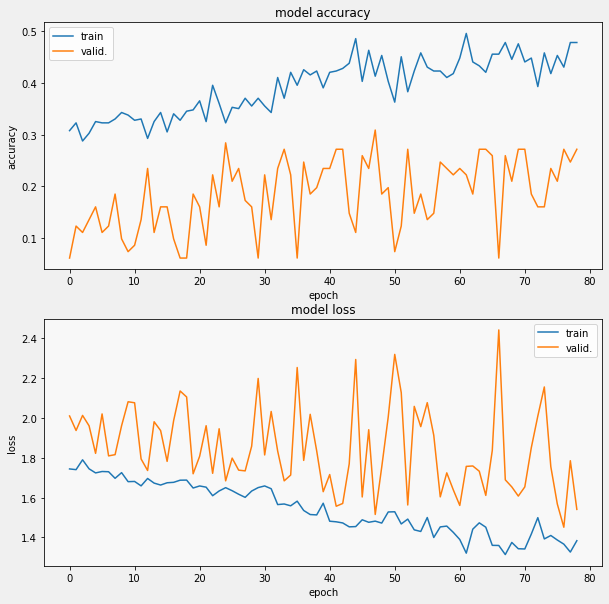

In [63]:
display_training_curves(history.history['accuracy'][1:], history.history['val_accuracy'][1:], 'accuracy', 211)
display_training_curves(history.history['loss'][1:], history.history['val_loss'][1:], 'loss', 212)

In [64]:
import pickle
with open('training_log/ResNet152_newdata408_withlayer_300px.pkl', 'wb') as output:
        pickle.dump(history.history, output)